## Example script: training and predicting with ConvLSTM
Author          : SSI project team Wadden Sea <br>
Description     : This notebook serves as an example of training and predicting with
                  Convolutional Long-Short Term Memeory Neural Network (ConvLSTM). <br>
Dependency      : os, numpy, pytorch <br>
Return Values   : array <br>
Caveat!         : This module performs many-to-one prediction! It supports CUDA. <br>


In [2]:
#This simulation with gpu (with the below parameters) took 14h

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional
from torch.autograd import Variable
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib as mpl
import glob
import xarray as xr
import dask as da
from tqdm import tqdm

# import convlstm----
home_dir = "/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
convlstm_model_dir=f"{ml_dir}src"
sys.path.append(convlstm_model_dir)
import convlstm
import convlstm_continuous_states

In [2]:
#path to files---
home_dir = "/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_post_proc_data=f"{ml_dir}post_proc_data/"
#
dir_displacement="net_displacement/"
dir_interp_wind="wind/"
dir_interp_bathymetry="bathymetry/"
file_interp_bathymetry="bathymetry_interp_to_particle_grid_for_convlstm.nc"
#for output after train and test---
exp="exp1d"
dir_convlstm_model_out="ouput_convlstm_model_data/"
case_train="training"; file_out_train=f"{exp}_train.nc"
case_test="testing"; file_out_test=f"{exp}_test.nc"

In [3]:
#for plotting--------
#dir_wind="{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_dws_bound0="dws_boundaries_contour0.nc"
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
file_topo="DWS200m.2012.v03.nc"
#
#parameters
#npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
#dx=400/1e3;dy=400/1e3 #particle grid reso
#
#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0
#
#open topo file
dsto=xr.open_dataset(dir_topo+file_topo) 
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)
mask_topo=dsto.bathymetry.copy(); mask_topo=xr.where(np.isfinite(mask_topo),1,0) #mask ocean=1, land=0

### Hyper-parameter of neural network

In [4]:
run_model = False #True = run model; False = open results from old run
input_channels = 3 # number of input channels: u10,v10 wind
output_channels = 2 #number of output channels: dx, dy displacement
#hidden_channels = [6, 3, output_channels] # the last digit is the output channel of each ConvLSTMCell (so we are using 3 layers)
hidden_channels = [4, output_channels] # the last digit is the output channel of each ConvLSTMCell (so we are using 2 layers)
kernel_size = 3 #3, does not work with kernel=2
mini_batch_size = 25 #Amount of samples for performing forward-backward propagation during 1 iteration (total iterations per epoch = train samples / mini_batch_size)
#mini_batch_size = 706 #aproox 1year. Amount of samples for performing forward-backward propagation during 1 iteration (total iterations per epoch = train samples / mini_batch_size)
#mini_batch_size = -1  #use all data for performing forward-backward propagation at once during 1 epoch. Memory issues for large samples during training.
num_epochs = 2 #3000 #100
#learning parameters:
adaptive_learning = False  #False: lr=learning_rate;  True: lr=[learning_rate - learning_rate_end]
#learning_rate = 0.0025 #too slow convergence if used since the beginning of simulation
learning_rate = 0.01 #initial lr
learning_rate_end=0.0025 #final lr
save_data_from_model = False #save some outputs from model in NetCDF Format
#
#if: hidden_channels = [6, 3, output_channels]
#the model will create 6GB of data in GPU memory after 400 training time steps
#so, after nt_steps=2000 (around 3y) we will exceed the mem limit of GPU (around 30GB)
#2.5years for training needs approx 26GB for the above model and with: input_channels = 2; output_channels = 2; kernel_size = 3
#this is because in every time step the graph of computations is stored in the cummulative lost (after calling the model), to perform then a backpropagation
#for this reason is sometimes important to use mini_batches and perform backpropagation after finish with 1.
#then use the next mini_batch and so on until using all the data and finishes 1 eppoch.

In [5]:
# import random
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

### Open files

In [6]:
#open net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#files_displacement=files_displacement[29:31]
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets
#dsdis

In [7]:
#open interp files for wind---
files_interp_wind=sorted(glob.glob(f'{dir_post_proc_data}{dir_interp_wind}*.nc',recursive=True))
#files_interp_wind=files_interp_wind[29:31]
#concat all the files
dswi=xr.open_mfdataset(files_interp_wind,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets
#dswi

In [8]:
#open interp bathymetry---
dsh=xr.open_dataset(dir_post_proc_data+dir_interp_bathymetry+file_interp_bathymetry).load()

In [9]:
# please specify output path for the model
# output_path = './model'
# if not os.path.exists(output_path):
#    os.makedirs(output_path, exist_ok = True)

### Format data

In [10]:
#set bathymetry as input data---
in_h=dsh.bathymetry.values

In [11]:
#set training data---
#
#inputs---
in_tini_train="2009-11-01"; in_tend_train="2009-12-31"
#u10,v10 wind in model coordinates---
#dswi_train=dswi.sel(time=slice("2009-06-01","2011-12-31"))#,x=slice(70000,80000),y=slice(60000,70000))
dswi_train=dswi.sel(time=slice(in_tini_train,in_tend_train))#,x=slice(60000,80000),y=slice(60000,70000))
in_u10_train,in_v10_train=da.compute(dswi_train.u10.values.astype('float32'),dswi_train.v10.values.astype('float32'))
#
#outputs---
out_tini_train="2009-11-01"; out_tend_train="2009-12-31"
#dx,dy displacement in model coordinates---
#dsdis_train=dsdis.sel(time=slice("2009-06-01","2011-12-31"))#,x=slice(70000,80000),y=slice(60000,70000))#dsdis_train=dsdis_train.fillna(0) #fill nan with 0s in case displacement is on land (not neccesary for the above small domain)
dsdis_train=dsdis.sel(time=slice(out_tini_train,out_tend_train))#,x=slice(70000,80000),y=slice(60000,70000))#dsdis_train=dsdis_train.fillna(0) #fill nan with 0s in case displacement is on land (not neccesary for the above small domain)
out_dx_train,out_dy_train=da.compute(dsdis_train.dx.values.astype('float32'),dsdis_train.dy.values.astype('float32'))
#
times_train=dsdis_train.time.values
nt_train,ny,nx=out_dx_train.shape
print(times_train[[0,-1]],out_dx_train.shape)

['2009-11-01T07:33:04.000000000' '2009-12-31T20:45:22.000000000'] (118, 133, 304)


In [12]:
#set testing data---
#
#inputs---
in_tini_test="2010-01-01"; in_tend_test="2010-02-28"
#u10,v10 wind in model coordinates---
#dswi_test=dswi.sel(time=slice("2012-01-01",None))#,x=slice(70000,80000),y=slice(60000,70000))
dswi_test=dswi.sel(time=slice(in_tini_test,in_tend_test))#,x=slice(60000,80000),y=slice(60000,70000))
in_u10_test,in_v10_test=da.compute(dswi_test.u10.values.astype('float32'),dswi_test.v10.values.astype('float32'))
#
#outputs---
out_tini_test="2010-01-01"; out_tend_test="2010-02-28"
#dx,dy displacement in model coordinates---
#dsdis_test=dsdis.sel(time=slice("2012-01-01",None))#,x=slice(70000,80000),y=slice(60000,70000))#dsdis_test=dsdis_test.fillna(0) #fill nan with 0s in case displacement is on land (not neccesary for the above small domain)
dsdis_test=dsdis.sel(time=slice(out_tini_test,out_tend_test))#,x=slice(70000,80000),y=slice(60000,70000))#dsdis_test=dsdis_test.fillna(0) #fill nan with 0s in case displacement is on land (not neccesary for the above small domain)
out_dx_test,out_dy_test=da.compute(dsdis_test.dx.values.astype('float32'),dsdis_test.dy.values.astype('float32'))
#
times_test=dsdis_test.time.values
nt_test,ny,nx=out_dx_test.shape
print(times_test[[0,-1]],out_dx_test.shape)

['2010-01-01T09:10:36.000000000' '2010-02-28T20:41:58.000000000'] (114, 133, 304)


In [13]:
#for plotting maps of predictions---
#mask: ocean=1, land=nan
mask=out_dx_train[0,...]*1.; mask[np.isfinite(mask)]=1.; mask[np.isnan(mask)]=np.nan
xx=dsdis_train.x/1e3; yy=dsdis_train.y/1e3; xx,yy=np.meshgrid(xx,yy)

#for masking values on land when computing loss---
mask_torch=torch.tensor(np.where(np.isnan(mask),0,1)[np.newaxis,np.newaxis,...]*np.ones((output_channels,ny,nx)))*1.
mask_numpy=mask_torch.numpy()*1.

In [14]:
#check hist of input training and input testing data---

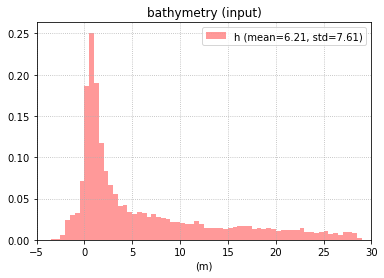

In [15]:
plt.hist(in_h.flatten(), bins=np.arange(-5,30.5,0.5), alpha=0.4, density=True, color='red', label=f'h (mean={np.nanmean(in_h.flatten()):.2f}, std={np.nanstd(in_h.flatten()):.2f})');
plt.xlim(-5,30);plt.legend(); plt.grid(ls=":")
plt.title("bathymetry (input)");plt.xlabel("(m)");

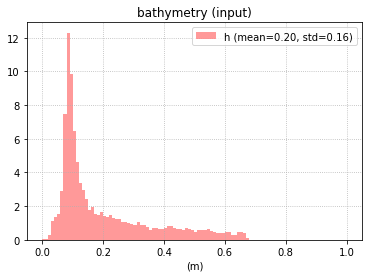

In [16]:
#min-max scalar because mean is not around peak
h0=(in_h.flatten()-np.nanmin(in_h))/(np.nanmax(in_h)-np.nanmin(in_h));#a0=(a0-np.nanmean(a0))*2
plt.hist(h0, bins=np.arange(0,1.01,0.01), alpha=0.4, density=True, color='red', label=f'h (mean={np.nanmean(h0):.2f}, std={np.nanstd(h0):.2f})');
#plt.xlim(-5,30);
plt.legend(); plt.grid(ls=":")
plt.title("bathymetry (input)");plt.xlabel("(m)");

In [17]:
a=in_u10_train.flatten(); b=in_v10_train.flatten()

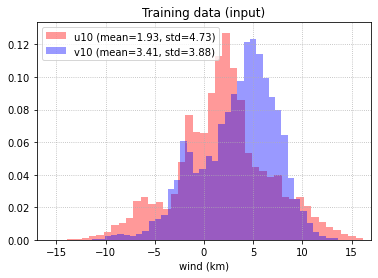

In [18]:
plt.hist(a, bins=40, alpha=0.4, density=True, color='red', label=f'u10 (mean={np.nanmean(a):.2f}, std={np.nanstd(a):.2f})');
plt.hist(b, bins=40, alpha=0.4, density=True, color='blue', label=f'v10 (mean={np.nanmean(b):.2f}, std={np.nanstd(b):.2f})');
plt.xlim(-17,17);plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("wind (km)");

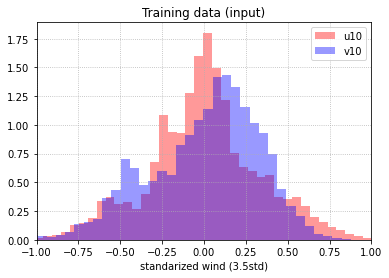

In [19]:
plt.hist((a-np.nanmean(a))/(3*np.nanstd(a)), bins=40, alpha=0.4, density=True, color='red', label=f'u10');
plt.hist((b-np.nanmean(b))/(3*np.nanstd(b)), bins=40, alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(-1,1); plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("standarized wind (3.5std)");
#del a,b

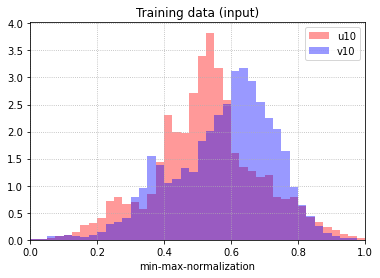

In [20]:
#min-max-normalization 
a0=(a-np.nanmin(a))/(np.nanmax(a)-np.nanmin(a));#a0=(a0-np.nanmean(a0))
b0=(b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b));#b0=(b0-np.nanmean(b0))
plt.hist(a0, bins=40, alpha=0.4, density=True, color='red', label=f'u10');
plt.hist(b0, bins=40, alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(0,1); plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("min-max-normalization");

In [21]:
#check hist of output training data---

In [22]:
a=out_dx_train.flatten(); b=out_dy_train.flatten()

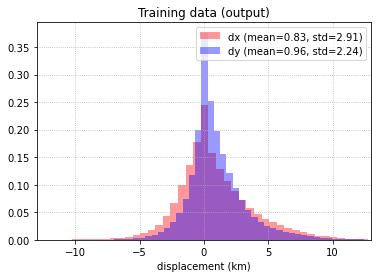

In [23]:
plt.hist(a, bins=60, alpha=0.4, density=True, color='red', label=f'dx (mean={np.nanmean(a):.2f}, std={np.nanstd(a):.2f})');
plt.hist(b, bins=60, alpha=0.4, density=True, color='blue', label=f'dy (mean={np.nanmean(b):.2f}, std={np.nanstd(b):.2f})');
plt.xlim(-13,13);plt.legend(); plt.grid(ls=":")
plt.title("Training data (output)");plt.xlabel("displacement (km)");

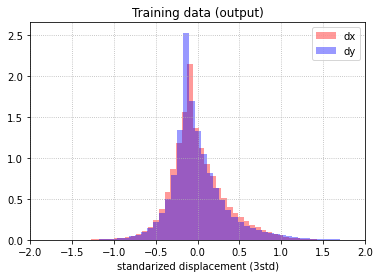

In [24]:
plt.hist((a-np.nanmean(a))/(3*np.nanstd(a)), bins=60, alpha=0.4, density=True, color='red', label=f'dx');
plt.hist((b-np.nanmean(b))/(3*np.nanstd(b)), bins=60, alpha=0.4, density=True, color='blue', label=f'dy');
plt.xlim(-2,2); plt.legend(); plt.grid(ls=":")
plt.title("Training data (output)");plt.xlabel("standarized displacement (3std)");

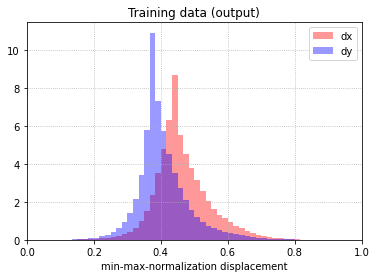

In [25]:
#min-max-normalization 
a0=(a-np.nanmin(a))/(np.nanmax(a)-np.nanmin(a)) #;a0=(a0-np.nanmean(a0))*2
b0=(b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b)) #;b0=(b0-np.nanmean(b0))*2
plt.hist(a0, bins=60, alpha=0.4, density=True, color='red', label=f'dx');
plt.hist(b0, bins=60, alpha=0.4, density=True, color='blue', label=f'dy');
plt.xlim(0,1); plt.legend(); plt.grid(ls=":")
plt.title("Training data (output)");plt.xlabel("min-max-normalization displacement");

In [26]:
def standarization(var,fac=3):
    mean=np.nanmean(var)
    std=np.nanstd(var)*fac #using 3 times std (seems to works better than just 1std)
    var[np.isnan(var)]=0. #fill with 0 in case of nan. This is modifing our input array
    return ((var-mean)/std),mean,std #.astype('float32')

def de_standarization(var,mean,std):
    return (var*std+mean) #.astype('float32')

def min_max_normalization(var):
    minn=np.nanmin(var); maxx=np.nanmax(var)
    var[np.isnan(var)]=0. #fill with 0 in case of nan. This is modifing our input array
    return (var-minn)/(maxx-minn),minn,maxx #.astype('float32')

def de_min_max_normalization(var,minn,maxx):
    return  var*(maxx-minn)+minn #.astype('float32')

In [27]:
#min-max normalization of data---

#input: bathymetry
in_h, in_h_min, in_h_max = min_max_normalization(in_h)


#standarization of data---

std_fac_dis=3 #standarize using "std_fac_dis" times the standard deviation
std_fac_wind=3 #standarize using "std_fac_wind" times the standard deviation

#training---
#inputs
in_u10_train, in_u10_mean_train, in_u10_std_train = standarization(in_u10_train,std_fac_wind)
in_v10_train, in_v10_mean_train, in_v10_std_train = standarization(in_v10_train,std_fac_wind)
#outputs
out_dx_train, out_dx_mean_train, out_dx_std_train = standarization(out_dx_train,std_fac_dis)
out_dy_train, out_dy_mean_train, out_dy_std_train = standarization(out_dy_train,std_fac_dis)
print("train info:")
print(f"steps={nt_train}; (ny,nx)=({ny},{nx})")
print("input")
print(f"u10_mean, u10_std*{std_fac_wind}, v10_mean, v10_std*{std_fac_wind}:")
print(in_u10_mean_train, in_u10_std_train, in_v10_mean_train, in_v10_std_train)
print("output")
print(f"dx_mean, dx_std*{std_fac_dis}, dy_mean, dy_std*{std_fac_dis}:")
print(out_dx_mean_train, out_dx_std_train, out_dy_mean_train, out_dy_std_train)
print()

#testing---
#inputs
in_u10_test, in_u10_mean_test, in_u10_std_test = standarization(in_u10_test,std_fac_wind)
in_v10_test, in_v10_mean_test, in_v10_std_test = standarization(in_v10_test,std_fac_wind)
#outputs
out_dx_test, out_dx_mean_test, out_dx_std_test = standarization(out_dx_test,std_fac_dis)
out_dy_test, out_dy_mean_test, out_dy_std_test = standarization(out_dy_test,std_fac_dis)
print("test info:")
print(f"steps={nt_test}; (ny,nx)=({ny},{nx})")
print("input")
print(f"u10_mean, u10_std*{std_fac_wind}, v10_mean, v10_std*{std_fac_wind}:")
print(in_u10_mean_test, in_u10_std_test, in_v10_mean_test, in_v10_std_test)
print("output")
print(f"dx_mean, dx_std*{std_fac_dis}, dy_mean, dy_std*{std_fac_dis}:")
print(out_dx_mean_test, out_dx_std_test, out_dy_mean_test, out_dy_std_test)
print()

train info:
steps=118; (ny,nx)=(133,304)
input
u10_mean, u10_std*3, v10_mean, v10_std*3:
1.9317092 14.175119876861572 3.4141865 11.651945114135742
output
dx_mean, dx_std*3, dy_mean, dy_std*3:
0.83351696 8.725868225097656 0.9550911 6.72948431968689

test info:
steps=114; (ny,nx)=(133,304)
input
u10_mean, u10_std*3, v10_mean, v10_std*3:
-1.2359074 14.375543117523193 0.8427789 10.695588827133179
output
dx_mean, dx_std*3, dy_mean, dy_std*3:
-0.14568049 8.207973003387451 0.4698859 5.837661981582642



### MODEL configuration and helper functions

#### Model initialization

In [28]:
#loss functions with and without masking---
class initialization:
    def __init__(self, masking=False, mask=None):
        self.masking=masking
        self.mask=mask

class loss_function:

    class mse(initialization):
        #we call this function without using its name
        def __call__(self, predict=torch.zeros(1), target=torch.zeros(1)):
            if self.masking:
                #masking land points---
                #
                #- the masking affect: 
                #    the value of the total loss (that only includes points inside DWS) and hence the last gradient of the backpropagation
                #    loss=sum(prediction-output)**2/N; dlos/dpred=2*sum(prediction-output)/N,
                #    with masking N is smaller because we dont consider land points, so seems that its like increasing the overall lr
                #- similar effect to masking without using it:
                #    if we use another custom loss like torch.nn.MSELoss(reduction='sum')
                #    masking is irrelevant since we dont divide with N
                #
                #disregard land points (=0) for the mean, so the loss value will increase
                #mask_torch: 0=land, 1=ocean
                #however, because we only have particles inside DWS, mask_torch=0 for the land and all points outside DWS
                loss_val = torch.mean(((predict-target)[self.mask==1])**2)
            else:
                #original---
                loss_val = torch.mean((predict-target)**2)  #=torch.nn.MSELoss()
            #
            return loss_val

    class mse_numpy(initialization):
        #we call this function without using its name
        def __call__(self, predict=np.zeros(1), target=np.zeros(1)):
            if self.masking:
                #masking land points---
                #disregard land points (=0) for the mean, so the loss value will increase
                #probably because land points decrease the loss, the model don't perform so well
                #mask_torch: 0=land, 1=ocean
                #however, because we only have particles inside DWS, mask_torch=0 all points except inside it
                loss_val = np.mean(((predict-target)[self.mask==1])**2)
            else:
                #original---
                loss_val = np.mean((predict-target)**2)  #=torch.nn.MSELoss()
            #
            return loss_val

### Training and testing

In [29]:
#function to get times for backward propagation when using mini-batch---
def get_times_for_backward(nt,mini_batch_size=30):
    #times relative to t=0
    if nt < mini_batch_size: mini_batch_size = nt  
    t_last = np.mod(nt,mini_batch_size)
    t_backward=np.arange(mini_batch_size,nt+1,mini_batch_size)-1
    #iterations = int(nt/mini_batch_size)
    #t_backward=np.arange(iterations)*mini_batch_size+mini_batch_size-1
    if t_backward[-1]!=nt-1: t_backward[-1]+=t_last
    return t_backward

In [30]:
#training---
def training(epoch,num_epochs,nt,t_backward,model):

    # Clear stored gradient
    model.zero_grad()
    optimizer.zero_grad()
    
    # loop through all timesteps
    predict=[]; loss0=0.; pred_bug=[]
    for t in range(nt):

        #stack data---
        #
        #old method using torch.autograd.Variable and .view()---
        #
        #data_in=np.stack((in_u10_train[t,...],in_v10_train[t,...]))
        #data_out=np.stack((out_dx_train[t,...],out_dy_train[t,...]))
        #data_in = torch.autograd.Variable(torch.Tensor(data_in).view(-1,input_channels,ny,nx)).to(device)
        #data_out = torch.autograd.Variable(torch.Tensor(data_out).view(-1,input_channels,ny,nx)).to(device)
        #
        #new method using  torch.tensor and np.newaxis (the same results as above)---
        data_in = torch.tensor(np.stack((in_u10_train[t,...],
                                         in_v10_train[t,...],
                                         in_h),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)
        data_out = torch.tensor(np.stack((out_dx_train[t,...],
                                          out_dy_train[t,...]),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)

        # Forward process and loss for:---
        #   - the entire batch (all the samples). Problems with memory.
        #   - mini-batch (subset of the full samples).
        #
        if t==0 or t in t_backward+1:  
            if t==0: # start hidden and cell states from a normal distribution
                predict0, _ = model(data_in, 0)
                mae0 = np.mean(abs(predict0-data_out).detach().cpu().numpy())
                #mape0 = np.mean( abs((predict0-data_out)/data_out).detach().numpy() ) #problems with mape if denominator = 0
            else: #use the last state of the previous mini-batch
                #if epoch == 0: print(f"give init states to model at time-step: {t}")
                print(f"give init states to model at time-step: {t}")
                predict0, _ = model(data_in, 0, states) #data_in=(1,input_channels,ny,nx) #predict0=(1,output_channels,ny,nx)
            #loss
            lossbp0 = loss_fn(predict0, data_out) #data_out=(1,output_channels,ny,nx)
            tt0=t
            #check if prediction uses random-init states after a backward propgation of a mini-batch
            if epoch == num_epochs-1: pred_bug.append(np.squeeze(predict0.detach().cpu().numpy()))
        else:
            if t in t_backward:
                #if epoch == 0: print(f"getting states from model at time-step: {t}")
                print(f"getting states from model at time-step: {t}")
                predict0, states = model(data_in, t-tt0)
            else:
                predict0, _ = model(data_in, t-tt0)
            #loss
            lossbp0 += loss_fn(predict0, data_out)
            mae0 += np.mean(abs(predict0-data_out).detach().cpu().numpy())
            #mape0 += np.mean( abs((predict0-data_out)/data_out).detach().numpy() )
        
        #Backward propagation for:---
        #  - the entire batch (all the samples). Problems with memory.
        #  - mini-batch (subset of the full samples).
        if t in t_backward: 
            if epoch == num_epochs-1:
                print(f"performing backward propagation at time-step: {t}")
            # Zero out gradient, else they will accumulate between epochs---
            model.zero_grad()
            optimizer.zero_grad()
            # Backward pass---
            lossbp0.backward()
            # Update parameters---
            optimizer.step() #to initiate gradient descent
            # Zero out gradient again, in case starting the model for the next mini-batch
            model.zero_grad()
            optimizer.zero_grad()
            #
            loss0 += lossbp0.item(); del lossbp0

    #cumulative loss from all the time steps (the loss we use for backward propagation)---
    if epoch % 50 == 0: 
        print("Train epoch ", epoch, "; mean(MSE(t)) = ", loss0/nt*std_fac_dis**2, "; mean(MAE(t)) = ", mae0/nt*std_fac_dis)
        print(np.sum(abs((states[-1][0]-predict0).detach().cpu().numpy())))
    
    # save lr
    lr0=optimizer.param_groups[0]["lr"]

    #predict train data for the last epoch, after updating model parameters
    #use all samples at once to run the model
    if epoch == num_epochs-1:
        with torch.no_grad():
            for t in range(nt):
                data_in = torch.from_numpy(np.stack((in_u10_train[t,...],
                                                     in_v10_train[t,...],
                                                     in_h),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)
                predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  predict=(1,output_channels,ny,nx)
                predict0 = np.squeeze(predict0.detach().cpu().numpy()) #delete the first dim=1
                predict.append(predict0) #save the predictions for the last epoch
            predict=np.array(predict) #(nt,output_channels,ny,nx)
            #predict=np.reshape(predict,(nt,output_channels,ny,nx)) #(nt,output_channels,ny,nx)

    return loss0, mae0, predict, model, lr0, np.array(pred_bug)


#testing---
def testing(epoch,num_epochs,nt,model):
    #this function avoid gradient storage (memory increases with time despite setting requires_grad=False)
    #https://discuss.pytorch.org/t/requires-grad-or-no-grad-in-prediction-phase/35759/2
    with torch.no_grad():

        predict=[]
        # loop through all timesteps
        for t in range(nt):

            # Forward process---
            #by default torch tensor: requires_grad=False---
            data_in = torch.tensor(np.stack((in_u10_test[t,...],
                                             in_v10_test[t,...],
                                             in_h),axis=0)[np.newaxis,...],requires_grad=False).to(device)  #(1,input_channels,ny,nx)
            #
            predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  pred_y=(1,output_channels,ny,nx)
            predict0 = predict0.detach().cpu().numpy()

            # Compute loss (and the cumulative loss from all the time steps)---
            data_out = np.stack((out_dx_test[t,...],
                                 out_dy_test[t,...]),axis=0)[np.newaxis,...]  #(1,input_channels,ny,nx)
            if t == 0:
                #loss0 = np.mean((predict0-data_out)**2)
                loss0 = loss_fn_np(predict0, data_out) #MSE numpy loss with mask on land points
                mae0 = np.mean(abs(predict0-data_out))
                #mape0=np.mean( abs((predict-data_out)/data_out).detach().numpy() ) #problems with mape if denominator = 0
            else:
                #loss0 += np.mean((predict0-data_out)**2)
                loss0 += loss_fn_np(predict0, data_out) #MSE numpy loss with mask on land points
                mae0 += np.mean(abs(predict0-data_out))
            
            if epoch == num_epochs-1: 
                predict.append(np.squeeze(predict0)) #save the predictions for the last epoch

        if epoch % 50 == 0: print("Test epoch ", epoch, "; mean(MSE(t)) = ", loss0/nt*std_fac_dis**2, "; mean(MAE(t)) = ", mae0/nt*std_fac_dis)

        #predict test data for the last epoch
        #if epoch == num_epochs-1:
        #    for t in range(nt):
        #        data_in = torch.tensor(np.stack((in_u10_test[t,...],
        #                                         in_v10_test[t,...],
        #                                         in_h),axis=0)[np.newaxis,...],requires_grad=False).to(device)  #(1,input_channels,ny,nx)
        #        predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  predict=(1,output_channels,ny,nx)
        #        predict0 = np.squeeze(predict0.detach().cpu().numpy()) #delete the first dim=1
        #        predict.append(predict0) #save the predictions for the last epoch
        #    predict=np.array(predict) #(nt,output_channels,ny,nx)
        #    #predict=np.reshape(predict,(nt,output_channels,ny,nx)) #(nt,output_channels,ny,nx)
            
        return loss0, mae0, np.array(predict)

In [31]:
#use cuda if possible---
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))
#print(f"{torch.cuda.get_device_name(0)}")

Pytorch version 1.8.1
Device to be used for computation: cpu


In [32]:
# initialize model---
if run_model:
    
    model = convlstm_continuous_states.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    #model = convlstm.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # choose loss function---
    #loss_fn = torch.nn.MSELoss()
    #loss_fn = loss_function.mse() #for training (the same as above)
    masking=True
    loss_fn = loss_function.mse(masking=masking,mask=mask_torch) #for training (masking land points)
    #loss_fn_np = loss_function.mse_numpy() #for testing
    loss_fn_np = loss_function.mse_numpy(masking=masking,mask=mask_numpy) #for testing
    # choose optimizer---
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # check the model and loss function and optimizer---
    print(model)
    print(loss_fn.__class__.__name__) #this works for pytorch, but also for our custom class
    #print(loss_fn) #only works for pytorch
    print(optimizer)

ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(2, 2, kernel_size=(3, 3), stride=

In [40]:
%%time 

#run simulation-----
if run_model:

    #mini-batch size to perform backward propagation---
    #mini_batch_size=25 
    if mini_batch_size==-1: mini_batch_size = nt_train
    nt_backward = get_times_for_backward(nt_train,mini_batch_size)
    print(f"time steps to activate backward propagation: {nt_backward} (len={len(nt_backward)})")
    print()
    
    #training output data---
    lr = np.zeros(num_epochs)
    loss_train = np.zeros(num_epochs) # save for every epoch the sum of loss for all the time steps for training data
    mae_train = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute error
    #problems with mape if denominator = 0
    #mape = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute percentage error

    #testing output data---
    loss_test = np.zeros(num_epochs) # save for every epoch the sum of loss for all the time steps for training data
    mae_test = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute error

    #adaptive learning rate---
    if adaptive_learning:
        #lrend = lrini*gamma^(epochs-1)
        #gamma = (lrend/lrini)^(1/(epochs-1))
        gamma=(learning_rate_end/learning_rate)**(1/(num_epochs-1))
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    #epochs---
    #for epoch in tqdm(range(num_epochs)):
    for epoch in range(num_epochs):
        #training---
        print(f"train, epoch = {epoch}");print()
        #loss_train[epoch], mae_train[epoch], predict_train, model, lr[epoch] = training(epoch,num_epochs,nt_train,nt_backward,model)
        loss_train[epoch], mae_train[epoch], predict_train, model, lr[epoch], pred_bug = training(epoch,num_epochs,nt_train,nt_backward,model)
        #testing---
        print(f"test, epoch = {epoch}");print()
        loss_test[epoch], mae_test[epoch], predict_test = testing(epoch,num_epochs,nt_test,model)
        #activate adaptive lr---
        
    #check memory usage of GPU---
    # torch.cuda.memory_reserved()/1e9 #GB  (this is the important one)
    # torch.cuda.memory_allocated()/1e6 #MB
    # print(torch.cuda.memory_summary()) #More info
    print()
    print(f"Mem reserved = {torch.cuda.memory_reserved()/1e9:.2f}GB (check this one),  Mem allocated = {torch.cuda.memory_allocated()/1e6:.2f}GB")
    # 2moths: 0.958398464GB, 4.911104GB
    # 3years: 17.037262848GB, 4.911104GB
    # 6years: out of memory. But if use 1year-mini_batch: 5.685379072GB, 4.911104GB

time steps to activate backward propagation: [ 24  49  74 117] (len=4)

train, epoch = 0

init random distribution states
init random distribution states
getting states from model at time-step: 24
performing backward propagation at time-step: 24
give init states to model at time-step: 25
continuous states
continuous states
getting states from model at time-step: 49
performing backward propagation at time-step: 49
give init states to model at time-step: 50
continuous states
continuous states
getting states from model at time-step: 74
performing backward propagation at time-step: 74
give init states to model at time-step: 75
continuous states
continuous states
getting states from model at time-step: 117
performing backward propagation at time-step: 117
Train epoch  0 ; mean(MSE(t)) =  0.8739505642551487 ; mean(MAE(t)) =  0.48886910131422134
0.0
test, epoch = 0

init random distribution states
init random distribution states
Test epoch  0 ; mean(MSE(t)) =  0.9612486738907663 ; mean(MAE(t)

time step =  0


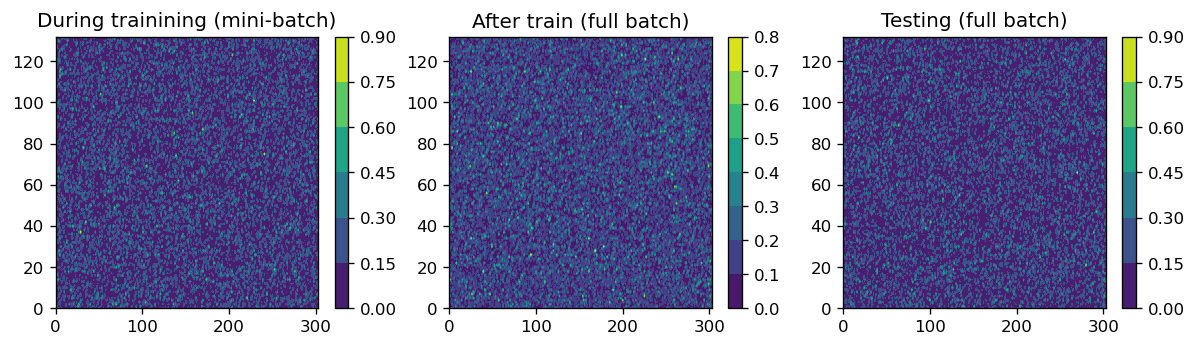

In [44]:
if run_model:
    #check predictions when lsmt is random init (at t=0 or after t=nt_backward)---
    times_random=np.r_[0,nt_backward[:-1]+1]
    it=0
    #
    fig,ax=plt.subplots(1,3,figsize=(12,3),dpi=120)
    cs=ax[0].contourf(pred_bug[it,0,...]**2+pred_bug[it,1,...]**2);plt.colorbar(cs,ax=ax[0]);ax[0].set_title("During trainining (mini-batch)")
    it2=times_random[it]
    cs=ax[1].contourf(predict_train[it2,0,...]**2+predict_train[it2,1,...]**2);plt.colorbar(cs,ax=ax[1]);ax[1].set_title("After train (full batch)")
    cs=ax[2].contourf(predict_test[it2,0,...]**2+predict_train[it2,1,...]**2);plt.colorbar(cs,ax=ax[2]);ax[2].set_title("Testing (full batch)")
    print("time step = ",times_random[it]) #time when lstm states are random initi

time step =  75


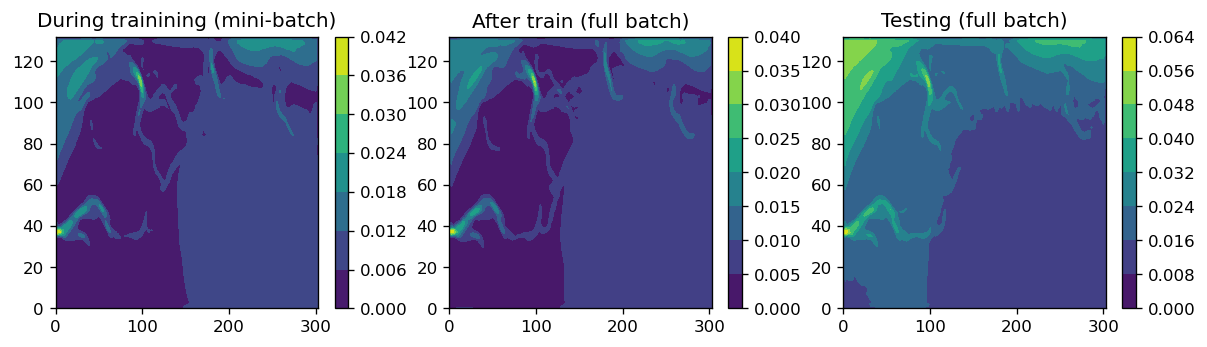

In [45]:
if run_model:
    #check predictions when lsmt is random init (at t=0 or after t=nt_backward)---
    times_random=np.r_[0,nt_backward[:-1]+1]
    it=3
    #
    fig,ax=plt.subplots(1,3,figsize=(12,3),dpi=120)
    cs=ax[0].contourf(pred_bug[it,0,...]**2+pred_bug[it,1,...]**2);plt.colorbar(cs,ax=ax[0]);ax[0].set_title("During trainining (mini-batch)")
    it2=times_random[it]
    cs=ax[1].contourf(predict_train[it2,0,...]**2+predict_train[it2,1,...]**2);plt.colorbar(cs,ax=ax[1]);ax[1].set_title("After train (full batch)")
    cs=ax[2].contourf(predict_test[it2,0,...]**2+predict_train[it2,1,...]**2);plt.colorbar(cs,ax=ax[2]);ax[2].set_title("Testing (full batch)")
    print("time step = ",times_random[it]) #time when lstm states are random initi

In [59]:
#save above data---
def save_data(case,time,loss,mae,pred,dir_out_nc,file_out_nc,lr=None):

    dsout = xr.Dataset()
    #global coords and attrs---
    dsout.coords["time"] = time
    dsout["time"].attrs['description'] = f'times every m2'
    dsout.coords["y"] = dsdis_train.y
    dsout["y"].attrs['description'] = 'y-position in meter'
    dsout.coords["x"] = dsdis_train.x
    dsout["x"].attrs['description'] = 'x-position in meter'
    dsout.coords["out_channels"] = np.arange(output_channels)
    dsout.coords["epoch"] = np.arange(num_epochs)
    #
    dsout.attrs["info"] = f"Data created after {case}"
    #
    #variables---
    #
    dsout["predict"] = (("time","out_channels","y","x"),pred)
    dsout["predict"].attrs['long_name'] = 'Standarized prediction for the last epoch'
    dsout["predict"].attrs['units'] = ""
    #
    dsout["loss"] = (("epoch"),loss)
    dsout["loss"].attrs['long_name'] = 'Loss = MSE from standarized prediction'
    #
    dsout["mae"] = (("epoch"),mae)
    dsout["mae"].attrs['long_name'] = 'Mean Absolute error = MAE from standarized prediction'
    #
    if case=="training":
        dsout["lr"] = (("epoch"),lr)
        dsout["lr"].attrs['long_name'] = 'Learning rate'
    #
    dsout["std_fac_predict"]=std_fac_dis
    dsout["std_fac_input_wind"]=std_fac_wind
    #
    dsout.to_netcdf(dir_out_nc+file_out_nc)
    dsout.close(); del dsout
#
if run_model and save_data_from_model:
    #train
    save_data(case_train,times_train,loss_train,mae_train,predict_train,dir_convlstm_model_out,file_out_train,lr)
    #test
    save_data(case_test,times_test,loss_test,mae_test,predict_test,dir_convlstm_model_out,file_out_test)

In [28]:
#open data---
dsout_train=xr.open_dataset(dir_convlstm_model_out+file_out_train); dsout_train.close()
dsout_test=xr.open_dataset(dir_convlstm_model_out+file_out_test); dsout_test.close()
#
loss_train=dsout_train.loss.values; mae_train=dsout_train.mae.values; predict_train=dsout_train.predict.values
loss_test=dsout_test.loss.values; mae_test=dsout_test.mae.values; predict_test=dsout_test.predict.values

In [29]:
if run_model:
    epochs=np.arange(num_epochs)+1
else:
    epochs=dsout_train.epoch.values+1
    nt_train=len(dsout_train.time)
    nt_test=len(dsout_test.time)
    std_fac_dis=dsout_train.std_fac_predict.values

In [30]:
#if we forgot to mask mae during simulation, we can at least try to just multiply by this correction factor, approx 3
#however because we forgot we are adding also mismatches on land points (but this is just a small efect)
#fac_mae=mask_numpy.size/((mask_numpy==1).sum())

### Check results for standarized variables

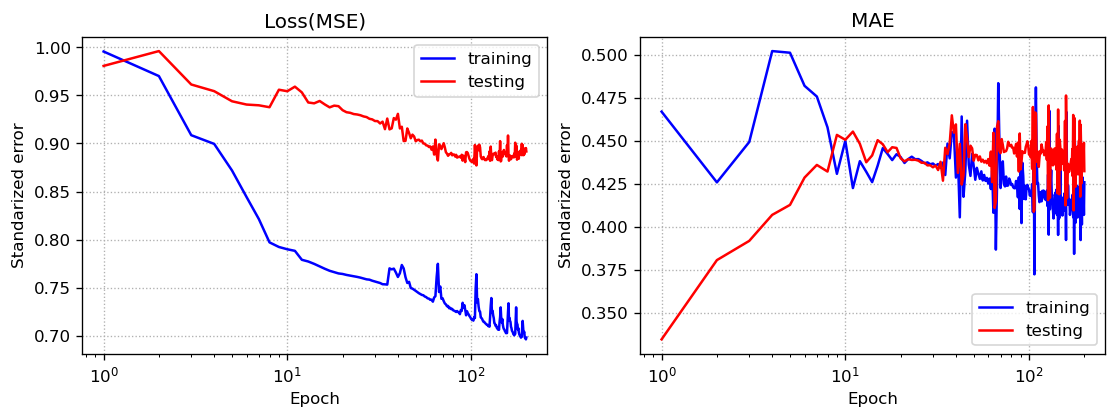

In [31]:
#spatial-temporal avg error for each epoch---
#the loss(MSE) and MAE are from the standarized variables
#for back-propagation we only used the loss(MSE)
#so error=1 means that error is close to 1std of the original data, approx: (std(dx)+std(dy))/2 
fig,ax=plt.subplots(1,2,figsize=(11,3.5),dpi=120)
#
ax[0].semilogx(epochs,loss_train/nt_train*std_fac_dis**2,'b',label='training') #because it was (standarized*3)^2
ax[0].semilogx(epochs,loss_test/nt_test*std_fac_dis**2,'r',label='testing') #because it was (standarized*3)^2
ax[0].set_xlabel('Epoch');ax[0].set_ylabel('Standarized error');ax[0].set_title("Loss(MSE)")
#ax[0].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
#ax[0].set_ylim(1.6,3.4); 
ax[0].grid(ls=":");ax[0].legend()
#
#spatial-temporal avg MAE for each epoch
ax[1].semilogx(epochs,mae_train/nt_train*std_fac_dis,'b',label='training')  #because it was standarized*3
ax[1].semilogx(epochs,mae_test/nt_test*std_fac_dis,'r',label='testing')  #because it was standarized*3
ax[1].set_xlabel('Epoch');ax[1].set_ylabel('Standarized error');ax[1].set_title("MAE")
#ax[1].set_ylabel('$\sum_t$ mae[epoch,t] / N',fontsize=12);
#ax[1].set_ylim(0.8,2.6); 
ax[1].grid(ls=":");ax[1].legend();
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

In [32]:
##check the errors for every time of the last epoch---
#in spite we random init our hidden and cell states, the errors are not huge at the beginning
#however this is because for the first time the displacement was weak
mask_numpy_nan=np.where(mask_numpy==0.,np.nan,1.)
print("standarized errors")
print()
#train---
#data_out=np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1)
mse_train_t=np.nanmean(((predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))**2)*mask_numpy_nan,axis=((1,2,3)))
mae_train_t=np.nanmean(abs(predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))*mask_numpy_nan,axis=((1,2,3)))
print("train")
print("mean(mse(t))=",np.mean(mse_train_t)*std_fac_dis**2)
print("mean(mse(t)) from model=",loss_train[-1]/nt_train*std_fac_dis**2)
#print("mean(mse(t)) using the final output matrix = ",abs((predict_train-data_out)**2).mean()*std_fac_dis**2)
print("mean(mae(t))=",np.mean(mae_train_t)*std_fac_dis)
print("mean(mae(t)) from model=",mae_train[-1]/nt_train*std_fac_dis)
#print("mean(mae(t)) using the final output matrix = ",abs((predict_train-data_out)).mean()*std_fac_dis)
print()

#test---
#data_out=np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1)
mse_test_t=np.nanmean(((predict_test-np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1))**2)*mask_numpy_nan,axis=((1,2,3)))
mae_test_t=np.nanmean(abs(predict_test-np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1))*mask_numpy_nan,axis=((1,2,3)))
print("test")
print("mean(mse(t))=",np.mean(mse_test_t)*std_fac_dis**2)
print("mean(mse(t)) from model=",loss_test[-1]/nt_test*std_fac_dis**2)
#print("mean(mse(t)) using the final output matrix = ",abs((predict_test-data_out)**2).mean()*std_fac_dis**2)
print("mean(mae(t))=",np.mean(mae_test_t)*std_fac_dis)
print("mean(mae(t)) from model=",mae_test[-1]/nt_test*std_fac_dis)
#print("mean(mae(t)) using the final output matrix = ",abs((predict_test-data_out)).mean()*std_fac_dis)
print()

standarized errors

train
mean(mse(t))= 0.6977289251471648
mean(mse(t)) from model= 0.6981726965661776
mean(mae(t))= 0.5871667049145547
mean(mae(t)) from model= 0.4259297968977589

test
mean(mse(t))= 0.8917361883220285
mean(mse(t)) from model= 0.8917362815455386
mean(mae(t))= 0.664404736416874
mean(mae(t)) from model= 0.4323990470484683



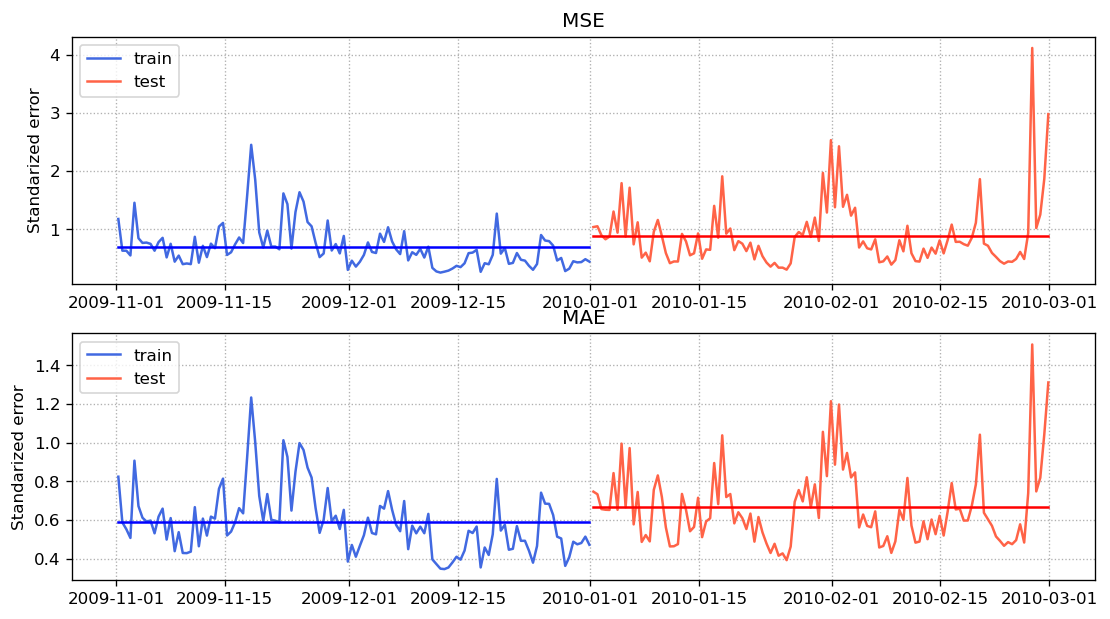

In [33]:
#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(11,6),dpi=120)
#
ax[0].plot(times_train,mse_train_t*std_fac_dis**2,'royalblue',label='train') #because it was (standarized*3)^2
ax[0].plot(times_test,mse_test_t*std_fac_dis**2,'tomato',label='test') #because it was (standarized*3)^2
ax[0].plot(times_train,mse_train_t.mean()*np.ones(times_train.size)*std_fac_dis**2,'-b')
ax[0].plot(times_test,mse_test_t.mean()*np.ones(times_test.size)*std_fac_dis**2,'-r')
ax[0].set_ylabel('Standarized error');ax[0].set_title("MSE")
#ax[0].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
ax[0].grid(ls=":");ax[0].legend()
#
#spatial-temporal avg MAE for each epoch
ax[1].plot(times_train,mae_train_t*std_fac_dis,'royalblue',label='train') #because it was (standarized*3)^2
ax[1].plot(times_test,mae_test_t*std_fac_dis,'tomato',label='test') #because it was (standarized*3)^2
ax[1].plot(times_train,mae_train_t.mean()*np.ones(times_train.size)*std_fac_dis,'-b')
ax[1].plot(times_test,mae_test_t.mean()*np.ones(times_test.size)*std_fac_dis,'-r')
ax[1].set_ylabel('Standarized error');ax[1].set_title("MAE")
#ax[1].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
ax[1].grid(ls=":");ax[1].legend();
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

/tmp/ipykernel_16719/2832225620.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall
/tmp/ipykernel_16719/2832225620.py:12: UserWarning: No contour levels were found within the data range.
  ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
/tmp/ipykernel_16719/2832225620.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set 

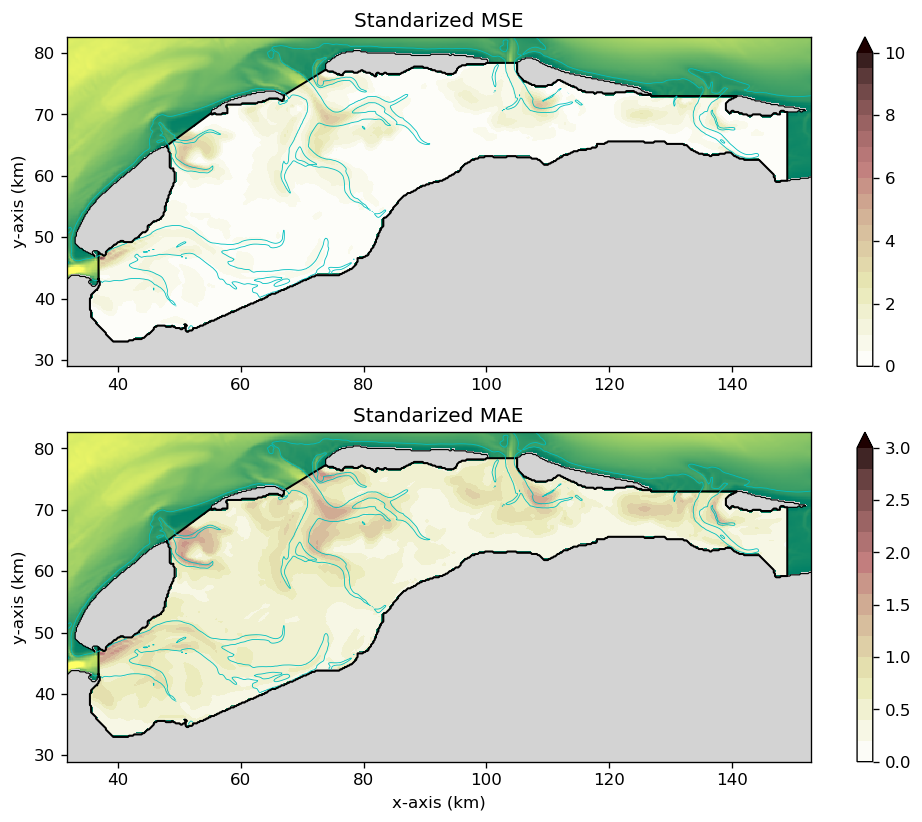

In [34]:
#spatial standarized errors---
mse_train_xy=(((predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))**2).mean(axis=(0,1))*std_fac_dis**2)*mask #to pun NaN again on land
mae_train_xy=(abs(predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1)).mean(axis=(0,1))*std_fac_dis)*mask #to pun NaN again on land

fig,ax=plt.subplots(2,1,figsize=(10,8),dpi=120)
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#MSE
val = np.ma.array(mse_train_xy, mask=np.isnan(mse_train_xy)) #mask because array has nan values
cs=ax[0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0].contourf(xx,yy,val,levels=np.arange(0,10.5,.5),cmap='pink_r',extend='max');plt.colorbar(cs,ax=ax[0],ticks=np.arange(0,12,2))
ax[0].axis("equal"); ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0].set_title("Standarized MSE")
ax[0].set_ylabel("y-axis (km)");#ax[0].set_xlabel("x-axis (km)");
#MAE
val = np.ma.array(mae_train_xy, mask=np.isnan(mae_train_xy)) #mask because array has nan values
cs=ax[1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,3.2,.2),cmap='pink_r',extend='max');plt.colorbar(cs,ax=ax[1],ticks=np.arange(0,3.5,.5))
ax[1].axis("equal"); ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[1].set_title("Standarized MAE")
ax[1].set_xlabel("x-axis (km)");ax[1].set_ylabel("y-axis (km)");
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

### Check results for variables with dimensions

In [35]:
#recover original units---

#multiply by mask to recover nan values on land (only for output and prediction data)

#training---
#input
in_u10_train = de_standarization(in_u10_train, in_u10_mean_train, in_u10_std_train)
in_v10_train = de_standarization(in_v10_train, in_v10_mean_train, in_v10_std_train)
#output
out_dx_train = de_standarization(out_dx_train, out_dx_mean_train, out_dx_std_train)*mask
out_dy_train = de_standarization(out_dy_train, out_dy_mean_train, out_dy_std_train)*mask
#prediction
pred_dx_train = de_standarization(predict_train[:,0,...], out_dx_mean_train, out_dx_std_train)*mask
pred_dy_train = de_standarization(predict_train[:,1,...], out_dy_mean_train, out_dy_std_train)*mask
print("training statistics")
print("real data")
print(np.nanmin(out_dx_train),np.nanmean(out_dx_train),np.nanmax(out_dx_train), np.nanmin(out_dy_train),np.nanmean(out_dy_train),np.nanmax(out_dy_train))
print("predictions")
print(np.nanmin(pred_dx_train),np.nanmean(pred_dx_train),np.nanmax(pred_dx_train), np.nanmin(pred_dy_train),np.nanmean(pred_dy_train),np.nanmax(pred_dy_train))
print()

#testing---
#input
in_u10_test = de_standarization(in_u10_test, in_u10_mean_test, in_u10_std_test)
in_v10_test = de_standarization(in_v10_test, in_v10_mean_test, in_v10_std_test)
#output
out_dx_test = de_standarization(out_dx_test, out_dx_mean_test, out_dx_std_test)*mask
out_dy_test = de_standarization(out_dy_test, out_dy_mean_test, out_dy_std_test)*mask
#prediction
pred_dx_test = de_standarization(predict_test[:,0,...], out_dx_mean_test, out_dx_std_test)*mask
pred_dy_test = de_standarization(predict_test[:,1,...], out_dy_mean_test, out_dy_std_test)*mask
print("testing statistics")
print("real data")
print(np.nanmin(out_dx_test),np.nanmean(out_dx_test),np.nanmax(out_dx_test), np.nanmin(out_dy_test),np.nanmean(out_dy_test),np.nanmax(out_dy_test))
print("predictions")
print(np.nanmin(pred_dx_test),np.nanmean(pred_dx_test),np.nanmax(pred_dx_test), np.nanmin(pred_dy_test),np.nanmean(pred_dy_test),np.nanmax(pred_dy_test))

training statistics
real data
-15.569101 0.83351696 19.798344 -10.854 0.9550911 18.212875
predictions
-4.5236583 0.8095324 7.6874166 -3.217678 0.8680164 6.0437965

testing statistics
real data
-18.244719 -0.14568049 20.60693 -11.675753 0.46988586 21.254671
predictions
-4.6401324 -0.28671396 6.6797523 -2.782782 0.37680033 5.0864663


In [36]:
##check the errors for every time of the last epoch---
#in spite we random init our hidden and cell states, the errors are not huge at the beginning
#however this is because for the first time the displacement was weak

#train---
rmse_dx_train_t=np.nanmean((pred_dx_train-out_dx_train)**2,axis=((1,2)))**.5
rmse_dy_train_t=np.nanmean((pred_dy_train-out_dy_train)**2,axis=((1,2)))**.5
mae_dx_train_t=np.nanmean(abs(pred_dx_train-out_dx_train),axis=((1,2)))
mae_dy_train_t=np.nanmean(abs(pred_dy_train-out_dy_train),axis=((1,2)))
print("train")
print(f"mean(rmse_dx(t)), mean(rmse_dy(t)) = {np.nanmean(rmse_dx_train_t):.2f}km, {np.nanmean(rmse_dy_train_t):.2f}km")
print(f"mean(mae_dx(t)), mean(mae_dy(t)) = {np.nanmean(mae_dx_train_t):.2f}km, {np.nanmean(mae_dy_train_t):.2f}km")
print()

#test---
rmse_dx_test_t=np.nanmean((pred_dx_test-out_dx_test)**2,axis=((1,2)))**.5
rmse_dy_test_t=np.nanmean((pred_dy_test-out_dy_test)**2,axis=((1,2)))**.5
mae_dx_test_t=np.nanmean(abs(pred_dx_test-out_dx_test),axis=((1,2)))
mae_dy_test_t=np.nanmean(abs(pred_dy_test-out_dy_test),axis=((1,2)))
print("test")
print(f"mean(rmse_dx(t)), mean(rmse_dy(t)) = {np.nanmean(rmse_dx_test_t):.2f}km, {np.nanmean(rmse_dy_test_t):.2f}km")
print(f"mean(mae_dx(t)), mean(mae_dy(t)) = {np.nanmean(mae_dx_test_t):.2f}km, {np.nanmean(mae_dy_test_t):.2f}km")
print()

train
mean(rmse_dx(t)), mean(rmse_dy(t)) = 2.22km, 1.92km
mean(mae_dx(t)), mean(mae_dy(t)) = 1.61km, 1.39km

test
mean(rmse_dx(t)), mean(rmse_dy(t)) = 2.42km, 1.82km
mean(mae_dx(t)), mean(mae_dy(t)) = 1.80km, 1.31km



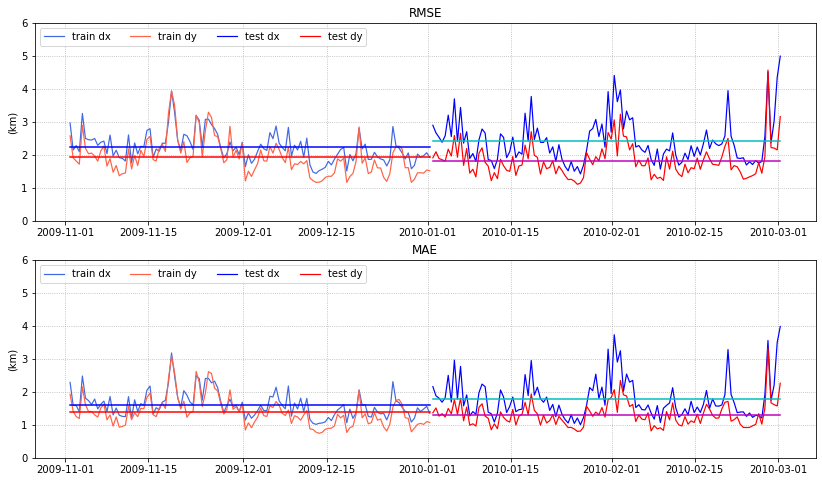

In [37]:
#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(14,8))
#
maxval=np.max((np.ceil(abs(np.concatenate((rmse_dx_train_t,rmse_dy_train_t,rmse_dx_test_t,rmse_dy_test_t))).max()),
               np.ceil(abs(np.concatenate((mae_dx_train_t,mae_dy_train_t,mae_dx_test_t,mae_dy_test_t))).max()) ))+1
#
#MSE
#train
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t.mean()*np.ones(times_train.size),ls='-',c='b')
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t.mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t.mean()*np.ones(times_test.size),ls='-',c='c')
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t.mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[0].set_ylim(0,maxval)
ax[0].set_ylabel('(km)');ax[0].set_title("RMSE")
ax[0].grid(ls=":");ax[0].legend(ncol=4,loc="upper left")
#
#MAE
#train
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t.mean()*np.ones(times_train.size),ls='-',c='b')
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t.mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t.mean()*np.ones(times_test.size),ls='-',c='c')
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t.mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[1].set_ylim(0,maxval)
ax[1].set_ylabel('(km)');ax[1].set_title("MAE")
ax[1].grid(ls=":");ax[1].legend(ncol=4,loc="upper left");

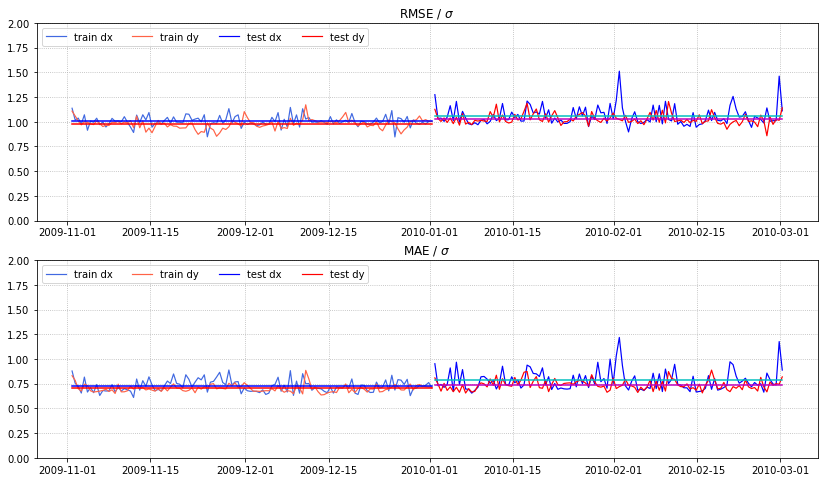

In [38]:
#the same as above but for the normalized errors (with std of output)
#
std_out_dx_train_t=np.nanstd(out_dx_train,axis=((1,2)))
std_out_dy_train_t=np.nanstd(out_dy_train,axis=((1,2)))
std_out_dx_test_t=np.nanstd(out_dx_test,axis=((1,2)))
std_out_dy_test_t=np.nanstd(out_dy_test,axis=((1,2)))
#

#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(14,8))
#
maxval=np.max((np.ceil(abs(np.concatenate((rmse_dx_train_t/std_out_dx_train_t,rmse_dy_train_t/std_out_dy_train_t,rmse_dx_test_t/std_out_dx_test_t,rmse_dy_test_t/std_out_dy_test_t))).max()),
               np.ceil(abs(np.concatenate((mae_dx_train_t/std_out_dx_train_t,mae_dy_train_t/std_out_dy_train_t,mae_dx_test_t/std_out_dx_test_t,mae_dy_test_t/std_out_dy_test_t))).max()) ))#+1
#
#MSE
#train
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t/std_out_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t/std_out_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),(rmse_dx_train_t/std_out_dx_train_t).mean()*np.ones(times_train.size),ls='-',c='b')
ax[0].plot(times_train+np.timedelta64(m2,'s'),(rmse_dy_train_t/std_out_dy_train_t).mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t/std_out_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t/std_out_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),(rmse_dx_test_t/std_out_dx_test_t).mean()*np.ones(times_test.size),ls='-',c='c')
ax[0].plot(times_test+np.timedelta64(m2,'s'),(rmse_dy_test_t/std_out_dy_test_t).mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[0].set_ylim(0,maxval)
ax[0].set_title(f"RMSE / $\sigma$"); ax[0].grid(ls=":");ax[0].legend(ncol=4,loc="upper left");
#
#MAE
#train
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t/std_out_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t/std_out_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),(mae_dx_train_t/std_out_dx_train_t).mean()*np.ones(times_train.size),ls='-',c='b')
ax[1].plot(times_train+np.timedelta64(m2,'s'),(mae_dy_train_t/std_out_dy_train_t).mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t/std_out_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t/std_out_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),(mae_dx_test_t/std_out_dx_test_t).mean()*np.ones(times_test.size),ls='-',c='c')
ax[1].plot(times_test+np.timedelta64(m2,'s'),(mae_dy_test_t/std_out_dy_test_t).mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[1].set_ylim(0,maxval)
ax[1].set_title(f"MAE / $\sigma$"); ax[1].grid(ls=":");ax[1].legend(ncol=4,loc="upper left");

In [39]:
#amount of data in below figure:
print(f"amount of output/predict train data = out_channels*nx*ny*nt = {output_channels*out_dx_train.size}")
print(f"amount of output/predict test data = out_channels*nx*ny*nt = {output_channels*out_dx_test.size}")

amount of output/predict train data = out_channels*nx*ny*nt = 9541952
amount of output/predict test data = out_channels*nx*ny*nt = 9218496


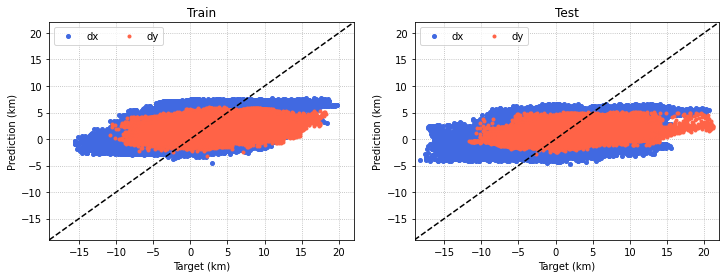

In [40]:
#take too much time when using several years---

fig,ax=plt.subplots(1,2,figsize=(12,4))
#
minval=np.min((np.floor(np.array((np.nanmin(out_dx_train),np.nanmin(pred_dx_train),np.nanmin(out_dy_train),np.nanmin(pred_dy_train))).min()),
               np.floor(np.array((np.nanmin(out_dx_test),np.nanmin(pred_dx_test),np.nanmin(out_dy_test),np.nanmin(pred_dy_test))).min()) ))
maxval=np.max((np.ceil(np.array((np.nanmax(out_dx_train),np.nanmax(pred_dx_train),np.nanmax(out_dy_train),np.nanmax(pred_dy_train))).max()),
               np.ceil(np.array((np.nanmax(out_dx_test),np.nanmax(pred_dx_test),np.nanmax(out_dy_test),np.nanmax(pred_dy_test))).max()) ))
#train
ax[0].plot(out_dx_train.flatten(),pred_dx_train.flatten(),'o',c="royalblue",ms=4,label='dx')
ax[0].plot(out_dy_train.flatten(),pred_dy_train.flatten(),'o',c="tomato",ms=3,label='dy')
ax[0].plot(np.linspace(minval,maxval,100),np.linspace(minval,maxval,100),'--k')
ax[0].set_xlabel('Target (km)');ax[0].set_ylabel('Prediction (km)');ax[0].set_title("Train")
ax[0].grid(ls=":");ax[0].legend(ncol=2,loc="upper left")
ax[0].axis([minval,maxval,minval,maxval]);
#test
ax[1].plot(out_dx_test.flatten(),pred_dx_test.flatten(),'o',c="royalblue",ms=4,label='dx')
ax[1].plot(out_dy_test.flatten(),pred_dy_test.flatten(),'o',c="tomato",ms=3,label='dy')
ax[1].plot(np.linspace(minval,maxval,100),np.linspace(minval,maxval,100),'--k')
ax[1].set_xlabel('Target (km)');ax[1].set_ylabel('Prediction (km)');ax[1].set_title("Test")
ax[1].grid(ls=":");ax[1].legend(ncol=2,loc="upper left")
ax[1].axis([minval,maxval,minval,maxval]);

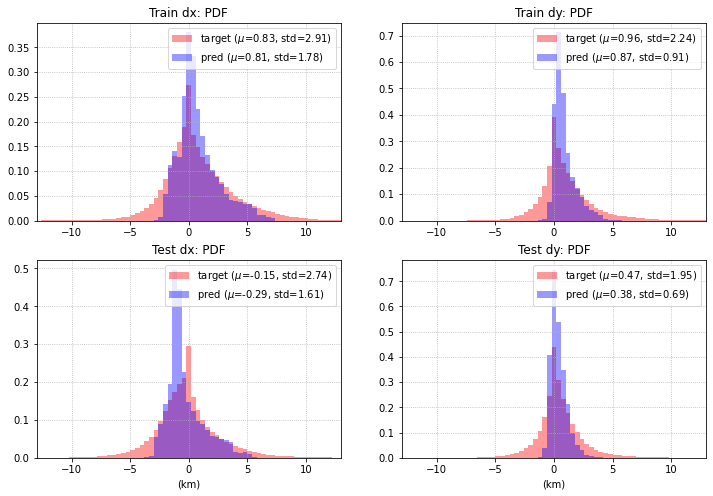

In [41]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
#train dx
ax[0,0].hist(out_dx_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dx_train):.2f}, std={np.nanstd(out_dx_train):.2f})');
ax[0,0].hist(pred_dx_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dx_train):.2f}, std={np.nanstd(pred_dx_train):.2f})');
ax[0,0].set_xlim(-13,13); ax[0,0].legend(); ax[0,0].grid(ls=":")
ax[0,0].set_title("Train dx: PDF")
#train dy
ax[0,1].hist(out_dy_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dy_train):.2f}, std={np.nanstd(out_dy_train):.2f})');
ax[0,1].hist(pred_dy_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dy_train):.2f}, std={np.nanstd(pred_dy_train):.2f})');
ax[0,1].set_xlim(-13,13); ax[0,1].legend(); ax[0,1].grid(ls=":")
ax[0,1].set_title("Train dy: PDF")
#
#test dx
ax[1,0].hist(out_dx_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dx_test):.2f}, std={np.nanstd(out_dx_test):.2f})');
ax[1,0].hist(pred_dx_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dx_test):.2f}, std={np.nanstd(pred_dx_test):.2f})');
ax[1,0].set_xlim(-13,13); ax[1,0].legend(); ax[1,0].grid(ls=":")
ax[1,0].set_title("Test dx: PDF");ax[1,0].set_xlabel("(km)");
#test dy
ax[1,1].hist(out_dy_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dy_test):.2f}, std={np.nanstd(out_dy_test):.2f})');
ax[1,1].hist(pred_dy_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dy_test):.2f}, std={np.nanstd(pred_dy_test):.2f})');
ax[1,1].set_xlim(-13,13); ax[1,1].legend(); ax[1,1].grid(ls=":")
ax[1,1].set_title("Test dy: PDF");ax[1,1].set_xlabel("(km)");

/tmp/ipykernel_16719/1950471163.py:3: RuntimeWarning: Mean of empty slice
  rmse_train_dx_xy=np.nanmean((pred_dx_train-out_dx_train)**2,axis=0)**.5
/tmp/ipykernel_16719/1950471163.py:4: RuntimeWarning: Mean of empty slice
  rmse_train_dy_xy=np.nanmean((pred_dy_train-out_dy_train)**2,axis=0)**.5
/tmp/ipykernel_16719/1950471163.py:5: RuntimeWarning: Mean of empty slice
  rmse_test_dx_xy=np.nanmean((pred_dx_test-out_dx_test)**2,axis=0)**.5
/tmp/ipykernel_16719/1950471163.py:6: RuntimeWarning: Mean of empty slice
  rmse_test_dy_xy=np.nanmean((pred_dy_test-out_dy_test)**2,axis=0)**.5
/tmp/ipykernel_16719/1950471163.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetr

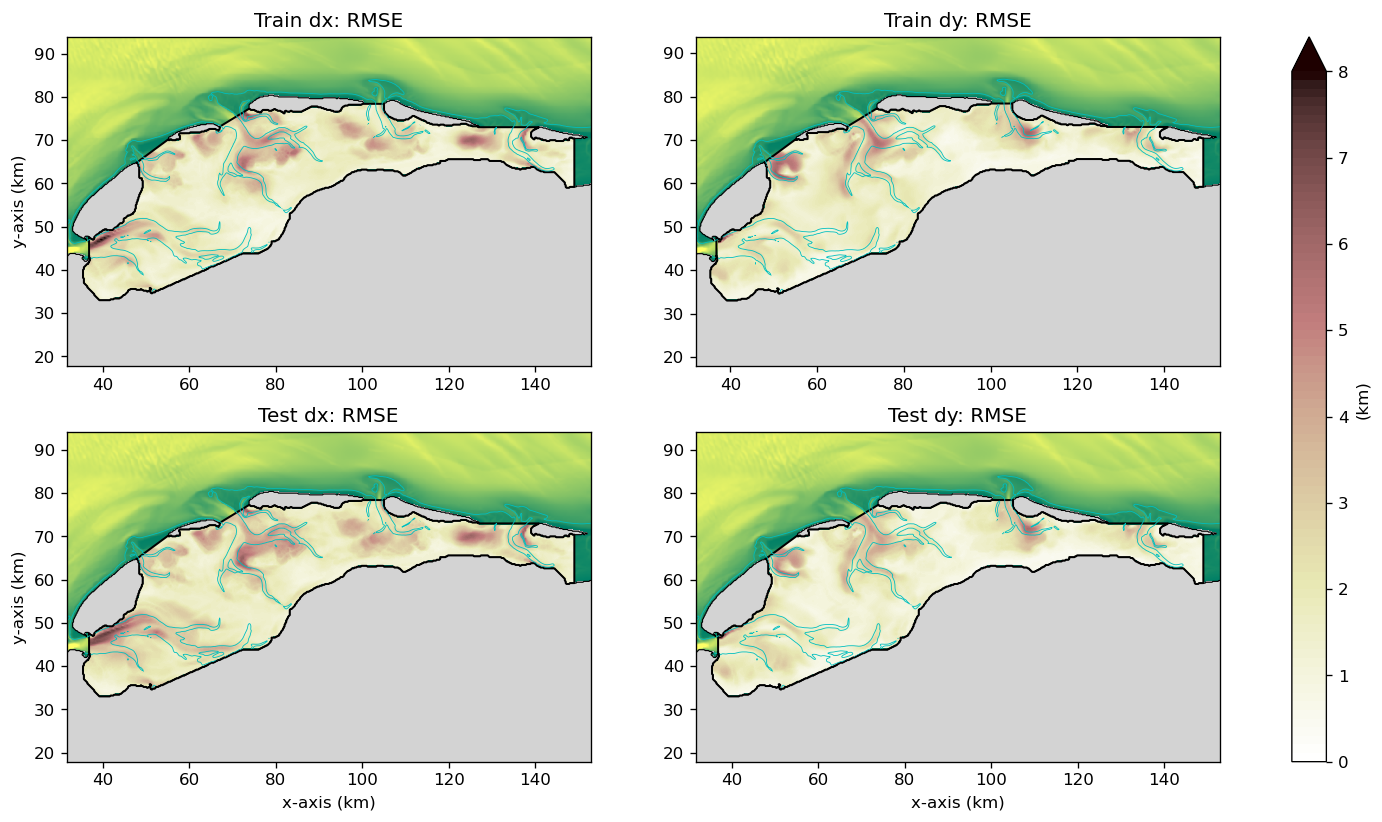

In [42]:
#spatial errors---

rmse_train_dx_xy=np.nanmean((pred_dx_train-out_dx_train)**2,axis=0)**.5
rmse_train_dy_xy=np.nanmean((pred_dy_train-out_dy_train)**2,axis=0)**.5
rmse_test_dx_xy=np.nanmean((pred_dx_test-out_dx_test)**2,axis=0)**.5
rmse_test_dy_xy=np.nanmean((pred_dy_test-out_dy_test)**2,axis=0)**.5

#plot---
fig,ax=plt.subplots(2,2,figsize=(15.5,8),dpi=120)
#
maxval=np.floor(np.array((np.nanmax(rmse_train_dx_xy),np.nanmax(rmse_train_dy_xy),
                          np.nanmax(rmse_test_dx_xy),np.nanmax(rmse_test_dy_xy))).max())
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#
val = np.ma.array(rmse_train_dx_xy, mask=np.isnan(rmse_train_dx_xy)) #mask because array has nan values
cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,0].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[0,0].axis("equal"); ax[0,0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0,0].set_title("Train dx: RMSE")
ax[0,0].set_ylabel("y-axis (km)");#ax[0,0].set_xlabel("x-axis (km)");
#
val = np.ma.array(rmse_train_dy_xy, mask=np.isnan(rmse_train_dy_xy)) #mask because array has nan values
cs=ax[0,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,1].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[0,1].axis("equal"); ax[0,1].axis([xx[0,1],xx[0,-1],yy[0,1],yy[-1,0]])
ax[0,1].set_title("Train dy: RMSE")
#
val = np.ma.array(rmse_test_dx_xy, mask=np.isnan(rmse_test_dx_xy)) #mask because array has nan values
cs=ax[1,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,0].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[1,0].axis("equal"); ax[1,0].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,0].set_title("Test dx: RMSE")
ax[1,0].set_xlabel("x-axis (km)");ax[1,0].set_ylabel("y-axis (km)");
#
val = np.ma.array(rmse_test_dy_xy, mask=np.isnan(rmse_test_dy_xy)) #mask because array has nan values
cs=ax[1,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,1].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[1,1].axis("equal"); ax[1,1].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,1].set_title("Test dy: RMSE")
ax[1,1].set_xlabel("x-axis (km)");
#
fig.colorbar(cs,ax=ax.ravel().tolist(),label="(km)",ticks=np.arange(0,maxval+1,1));
#old method (control size)
#cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#fig.colorbar(cs, cax=cbar_ax,label="(km)",title="RMSE")

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_16719/1082840993.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall
/tmp/ipykernel_16719/1082840993.py:19: UserWarning: No contour levels were found within the data range.
  ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
/tmp/ipykernel_16719/

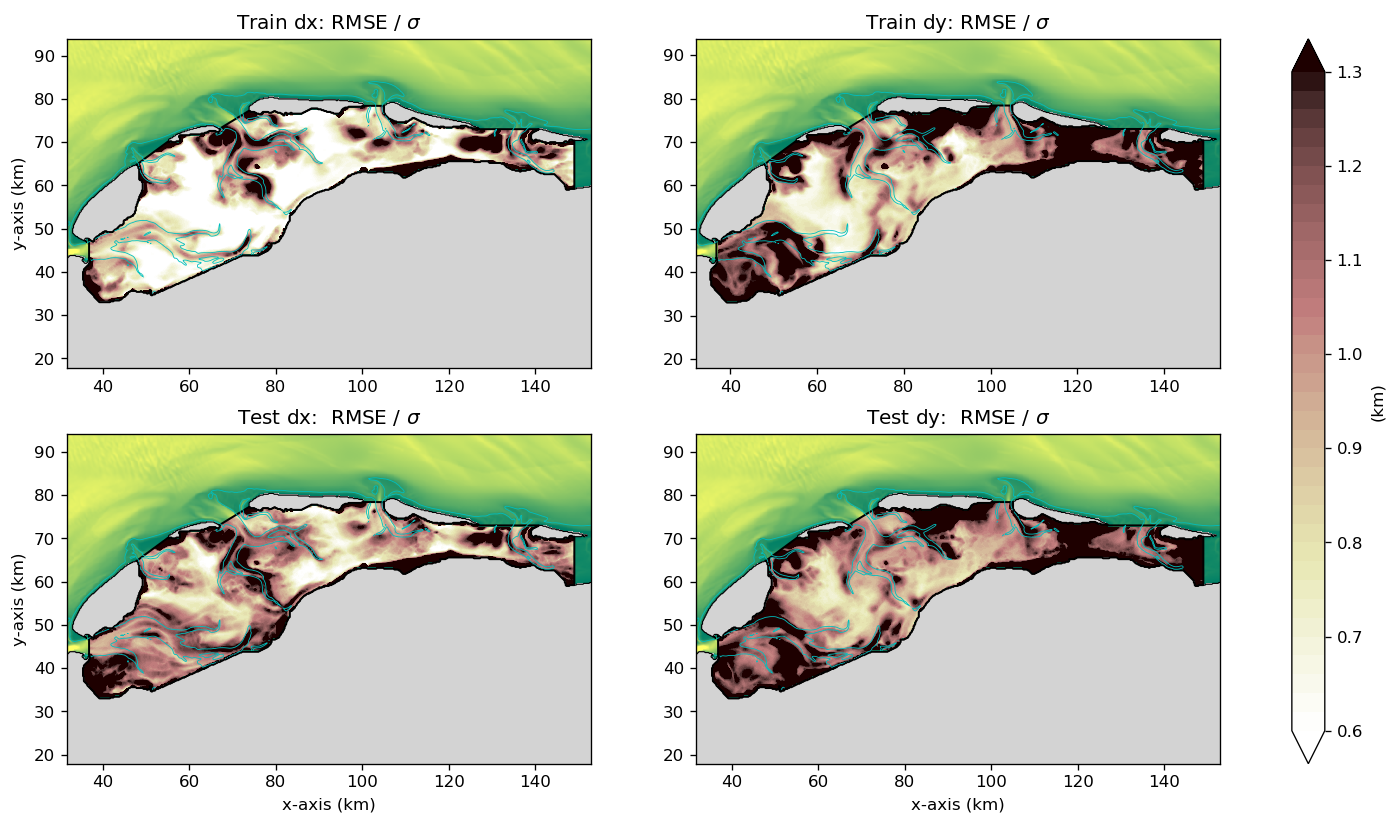

In [43]:
#spatial errors normalized with std---
std_out_dx_train_xy=np.nanstd(out_dx_train,axis=0)
std_out_dy_train_xy=np.nanstd(out_dy_train,axis=0)
std_out_dx_test_xy=np.nanstd(out_dx_test,axis=0)
std_out_dy_test_xy=np.nanstd(out_dy_test,axis=0)

#plot---
fig,ax=plt.subplots(2,2,figsize=(15.5,8),dpi=120)
#
#maxval=np.floor(np.array(((rmse_train_dx_xy/std_out_dx_train_xy).max(),(rmse_train_dy_xy/std_out_dy_train_xy).max(),
#                          (rmse_test_dx_xy/std_out_dx_test_xy).max(),(rmse_test_dy_xy/std_out_dy_test_xy).max())).max())
minval=0.6;maxval=1.3
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#
val = np.ma.array(rmse_train_dx_xy, mask=np.isnan(rmse_train_dx_xy))/std_out_dx_train_xy #mask because array has nan values
cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,0].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[0,0].axis("equal"); ax[0,0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0,0].set_title(f"Train dx: RMSE / $\sigma$")
ax[0,0].set_ylabel("y-axis (km)");#ax[0,0].set_xlabel("x-axis (km)");
#
val = np.ma.array(rmse_train_dy_xy, mask=np.isnan(rmse_train_dy_xy))/std_out_dy_train_xy #mask because array has nan values
cs=ax[0,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,1].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[0,1].axis("equal"); ax[0,1].axis([xx[0,1],xx[0,-1],yy[0,1],yy[-1,0]])
ax[0,1].set_title(f"Train dy: RMSE / $\sigma$")
#
val = np.ma.array(rmse_test_dx_xy, mask=np.isnan(rmse_test_dx_xy))/std_out_dx_test_xy #mask because array has nan values
cs=ax[1,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,0].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[1,0].axis("equal"); ax[1,0].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,0].set_title(f"Test dx:  RMSE / $\sigma$")
ax[1,0].set_xlabel("x-axis (km)");ax[1,0].set_ylabel("y-axis (km)");
#
val = np.ma.array(rmse_test_dy_xy, mask=np.isnan(rmse_test_dy_xy))/std_out_dy_test_xy #mask because array has nan values
cs=ax[1,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,1].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[1,1].axis("equal"); ax[1,1].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,1].set_title(f"Test dy:  RMSE / $\sigma$")
ax[1,1].set_xlabel("x-axis (km)");
#
fig.colorbar(cs,ax=ax.ravel().tolist(),label="(km)",ticks=np.arange(minval,maxval+.1,.1));
#old method (control size)
#cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#fig.colorbar(cs, cax=cbar_ax,label="(km)",title="RMSE")

In [44]:
### Check training-----

In [45]:
def plotting_train(ii,tt,scale=200,width=0.0038):
    
    fig,ax=plt.subplots(1,3,figsize=(16,3.5),dpi=120)

    iyy=6;ixx=6
        
    #data input at t=t0---
    print(tt)
    #val=(u10_train[ii+1,...]**2+v10_train[ii+1,...]**2)**.5
    val=(in_u10_train[ii,...]**2+in_v10_train[ii,...]**2)**.5
    #plt.contourf(xx,yy,val,cmap='jet');plt.colorbar()
    cs=ax[0].contourf(xx,yy,val*mask,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[0],label='(km)')
    ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[0].axis("equal");
    q=ax[0].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],in_u10_train[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],in_v10_train[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    #ax[0].quiverkey(q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
    ax[0].set_title("predictor wind at T0")
    ax[0].set_xlabel("x-axis (km)");ax[0].set_ylabel("y-axis (km)");

    ##data output at t=t0+M2---
    val=(out_dx_train[ii,...]**2+out_dy_train[ii,...]**2)**.5
    cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[1],label='(km)')
    ax[1].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])#;ax[1].axis("equal"); 
    ax[1].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],out_dx_train[ii,...][::iyy,::ixx],out_dy_train[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[1].set_title("true (net dis) at T0")
    ax[1].set_xlabel("x-axis (km)")

    #prediction at t=t0+M2---
    valp=(pred_dx_train[ii,...]**2+pred_dy_train[ii,...]**2)**.5
    cs=ax[2].contourf(xx,yy,valp,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[2],label='(km)')
    ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[2].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[2].axis("equal")
    ax[2].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],pred_dx_train[ii,...][::iyy,::ixx],pred_dy_train[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[2].set_title("prediction (net dis) at T0")
    ax[2].set_xlabel("x-axis (km)");
    
    fig.colorbar(cs,ax=ax.ravel().tolist(),label='(km)');
    
    #with units---
    print(f"rmse_dx={rmse_dx_train_t[ii]:.2f}km, rmse_dy={rmse_dy_train_t[ii]:.2f}km, sqrt(mse_dx+mse_dy)={(rmse_dx_train_t[ii]**2+rmse_dy_train_t[ii]**2)**.5:.2f}km, rmse_magnitude={np.nanmean((val-valp)**2)**.5:.2f}km")
    #the same as above
    #print(f"rmse_dx={np.mean((out_dx_train[ii,...]-pred_dx_train[ii,...])**2)**.5:.2f}km, rmse_dy={np.mean((out_dy_train[ii,...]-pred_dy_train[ii,...])**2)**.5:.2f}km, sqrt(mse_dx+mse_dy)={np.mean((out_dx_train[ii,...]-pred_dx_train[ii,...])**2+(out_dy_train[ii,...]-pred_dy_train[ii,...])**2)**.5:.2f}km")
    #without units---
    print(f"standarized mse_dx+mse_dy = {mse_train_t[ii]*9:.2f}")
    print()
    #fig.savefig(f'figures/prediction-{tt}.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

In [46]:
# ii=nt_train-70
# tt=str(times_train[ii])[:19].replace(":","-")
# plotting_train(ii,tt)

2009-11-25T15-19-02
rmse_dx=2.80km, rmse_dy=2.58km, sqrt(mse_dx+mse_dy)=3.80km, rmse_magnitude=2.96km
standarized mse_dx+mse_dy = 1.12



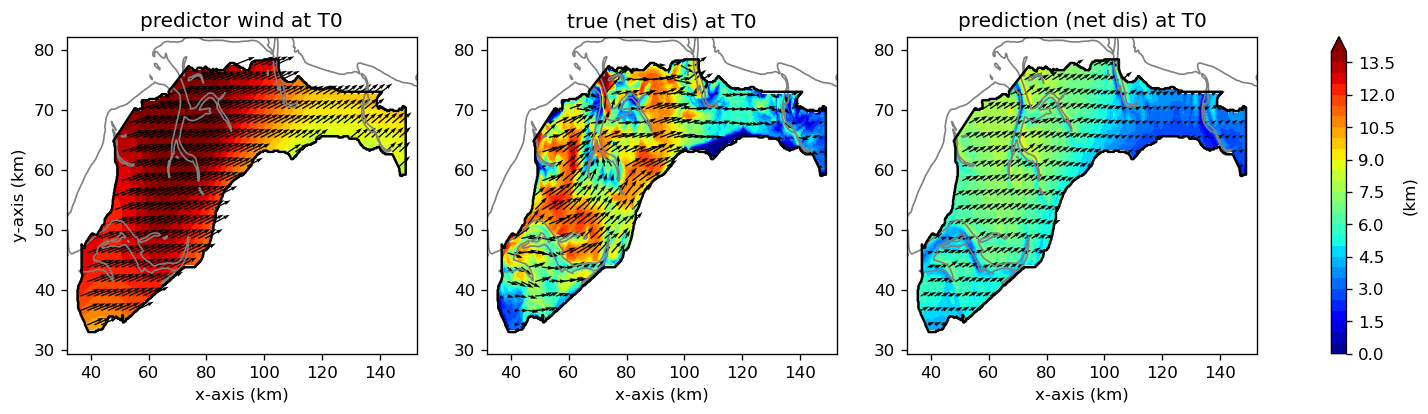

In [47]:
ii=np.nonzero(times_train==np.datetime64("2009-11-25T15:19:02"))[0][0]
tt=str(times_train[ii])[:19].replace(":","-")
plotting_train(ii,tt)

2009-12-23T01-36-24
rmse_dx=1.93km, rmse_dy=1.60km, sqrt(mse_dx+mse_dy)=2.51km, rmse_magnitude=1.92km
standarized mse_dx+mse_dy = 0.48



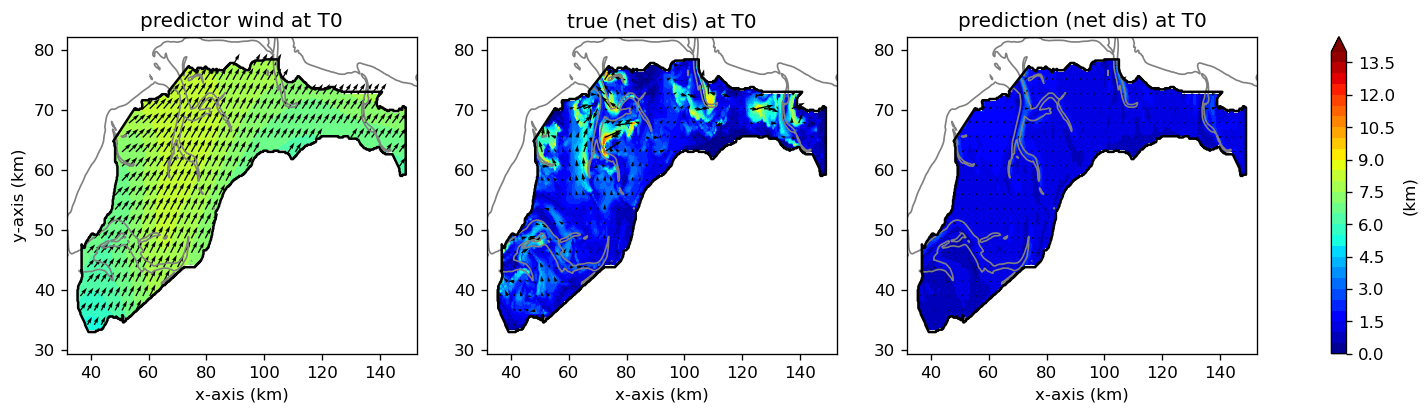

In [48]:
ii=nt_train-136
tt=str(times_train[ii])[:19].replace(":","-")
plotting_train(ii,tt)

In [49]:
### Check testing-----

In [50]:
#check in testing times of min and max error (use the standarized error to find dates)---
ii0=np.nonzero(mse_test_t==mse_test_t.min())[0][0]
print(ii0,mse_test_t[ii0]*9)
ii1=np.nonzero(mse_test_t==mse_test_t.max())[0][0]
print(ii1,mse_test_t[ii1]*9)

48 0.3054962246748573
109 4.117030706066192


In [51]:
def plotting_test(ii,tt,scale=200,width=0.0038):
    
    fig,ax=plt.subplots(1,3,figsize=(16,3.5),dpi=120)

    iyy=6;ixx=6
        
    #data input at t=t0---
    print(tt)
    #val=(u10_test[ii+1,...]**2+v10_test[ii+1,...]**2)**.5
    val=(in_u10_test[ii,...]**2+in_v10_test[ii,...]**2)**.5
    #plt.contourf(xx,yy,val,cmap='jet');plt.colorbar()
    cs=ax[0].contourf(xx,yy,val*mask,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[0],label='(km)')
    ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[0].axis("equal");
    q=ax[0].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],in_u10_test[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],in_v10_test[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    #ax[0].quiverkey(q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
    ax[0].set_title("predictor (net dis) at T0")
    ax[0].set_xlabel("x-axis (km)");ax[0].set_ylabel("y-axis (km)");

    ##data output at t=t0+M2---
    val=(out_dx_test[ii,...]**2+out_dy_test[ii,...]**2)**.5
    cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[1],label='(km)')
    ax[1].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])#;ax[1].axis("equal"); 
    ax[1].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],out_dx_test[ii,...][::iyy,::ixx],out_dy_test[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[1].set_title("true (net dis) at T0")
    ax[1].set_xlabel("x-axis (km)")

    #prediction at t=t0+M2---
    valp=(pred_dx_test[ii,...]**2+pred_dy_test[ii,...]**2)**.5
    cs=ax[2].contourf(xx,yy,valp,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[2],label='(km)')
    ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[2].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[2].axis("equal")
    ax[2].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],pred_dx_test[ii,...][::iyy,::ixx],pred_dy_test[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[2].set_title("prediction (net dis) at T0")
    ax[2].set_xlabel("x-axis (km)");
    
    fig.colorbar(cs,ax=ax.ravel().tolist(),label='(km)');
    
    #with units---
    print(f"rmse_dx={rmse_dx_test_t[ii]:.2f}km, rmse_dy={rmse_dy_test_t[ii]:.2f}km, sqrt(mse_dx+mse_dy)={(rmse_dx_test_t[ii]**2+rmse_dy_test_t[ii]**2)**.5:.2f}km, rmse_magnitude={np.nanmean((val-valp)**2)**.5:.2f}km")
    #the same as above
    #print(f"rmse_dx={np.mean((out_dx_test[ii,...]-pred_dx_test[ii,...])**2)**.5:.2f}km, rmse_dy={np.mean((out_dy_test[ii,...]-pred_dy_test[ii,...])**2)**.5:.2f}km, sqrt(mse_dx+mse_dy)={np.mean((out_dx_test[ii,...]-pred_dx_test[ii,...])**2+(out_dy_test[ii,...]-pred_dy_test[ii,...])**2)**.5:.2f}km")
    #without units---
    print(f"standarized mse_dx+mse_dy = {mse_test_t[ii]*9:.2f}")
    print()
    #fig.savefig(f'figures/prediction-{tt}.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

2010-01-26T05-21-48
rmse_dx=1.42km, rmse_dy=1.14km, sqrt(mse_dx+mse_dy)=1.82km, rmse_magnitude=1.28km
standarized mse_dx+mse_dy = 0.31



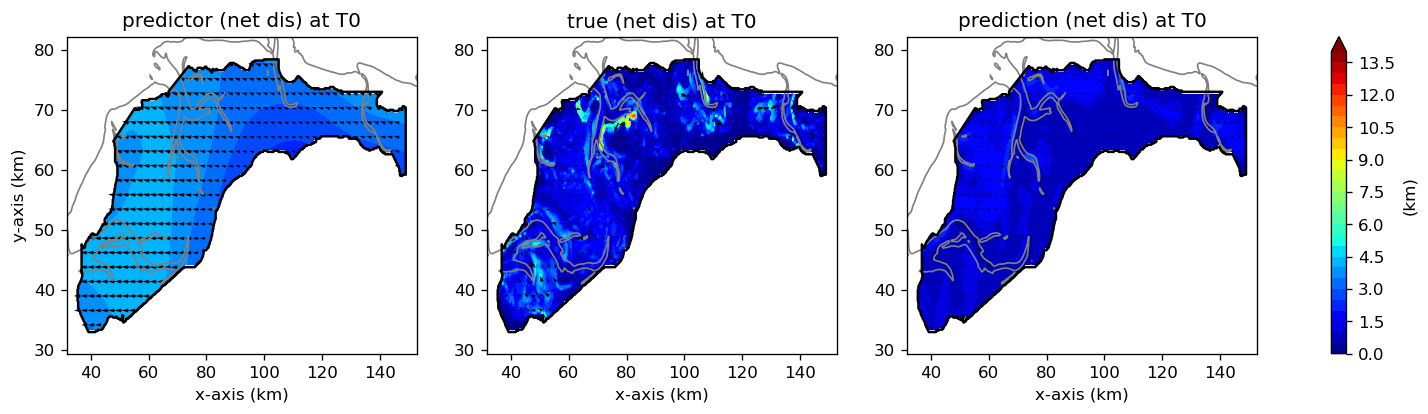

In [52]:
tt=str(times_test[ii0])[:19].replace(":","-")
plotting_test(ii0,tt)

2010-02-26T19-01-02
rmse_dx=4.51km, rmse_dy=4.57km, sqrt(mse_dx+mse_dy)=6.42km, rmse_magnitude=5.22km
standarized mse_dx+mse_dy = 4.12



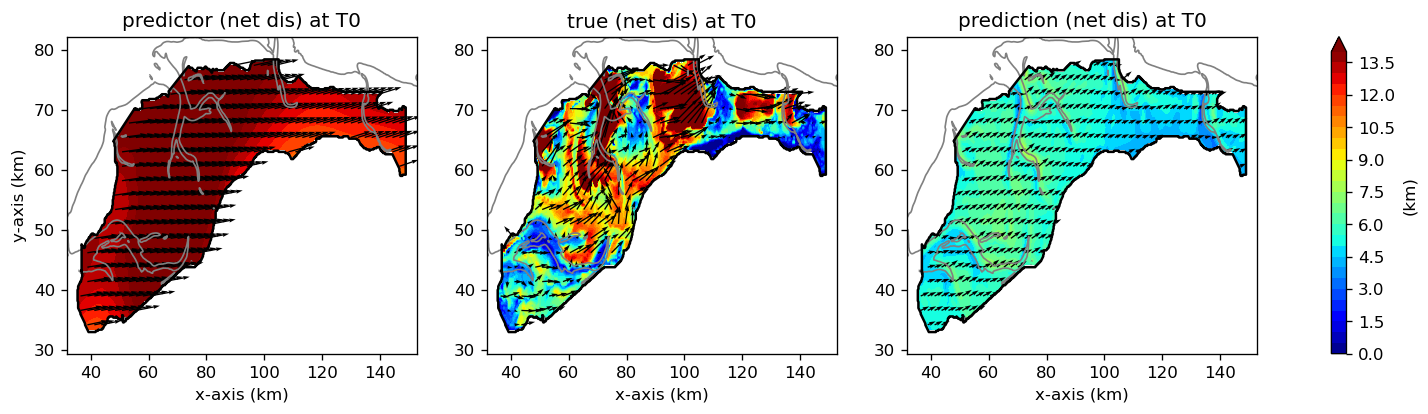

In [53]:
#2012-11-24T17-12-46
tt=str(times_test[ii1])[:19].replace(":","-")
plotting_test(ii1,tt)

2010-02-27T07-26-16
rmse_dx=2.36km, rmse_dy=2.22km, sqrt(mse_dx+mse_dy)=3.24km, rmse_magnitude=2.34km
standarized mse_dx+mse_dy = 1.02



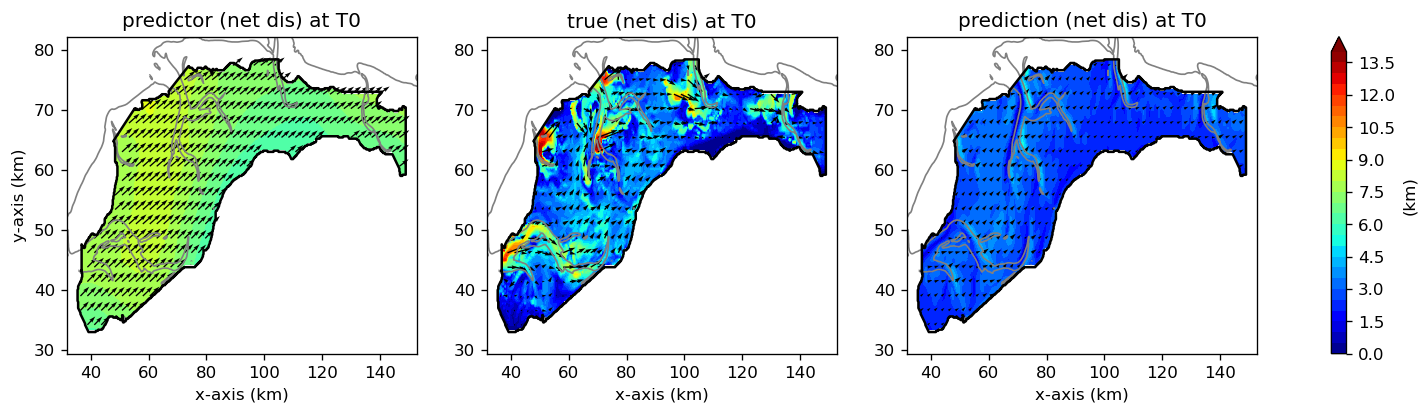

In [54]:
tt=str(times_test[ii1+1])[:19].replace(":","-")
plotting_test(ii1+1,tt)

In [55]:
### circular mean and std of angles (without taking into account the magnitude of vector)
#
#https://en.wikipedia.org/wiki/Directional_statistics#The_fundamental_difference_between_linear_and_circular_statistics


# def _circfuncs_common2(samples, high, low):
#     # Ensure samples are array-like and size is not zero
#     samples = np.asarray(samples)
#     if samples.size == 0:
#         return np.nan, np.asarray(np.nan), np.asarray(np.nan)

#     # Recast samples as radians that range between 0 and 2 pi and calculate
#     # the sine and cosine
#     sin_samp = sin((samples - low)*2.*pi / (high - low))
#     cos_samp = cos((samples - low)*2.*pi / (high - low))

#     return samples, sin_samp, cos_samp


# def circstd2(samples, high=2*pi, low=0, axis=None):
#     samples, sin_samp, cos_samp = _circfuncs_common2(samples, high, low)
#     sin_mean = sin_samp.mean(axis=axis)
#     cos_mean = cos_samp.mean(axis=axis)
#     # hypot can go slightly above 1 due to rounding errors
#     print(sin_mean, cos_mean,hypot(sin_mean, cos_mean))
#     with np.errstate(invalid='ignore'):
#         R = np.minimum(1, hypot(sin_mean, cos_mean))
#         print(R)

#     return  sqrt(-2*log(R))


# num_epochs=100
# from scipy.stats import circmean,circstd
# from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
#                    arange, sort, amin, amax, atleast_1d, sqrt, array,
#                    compress, pi, exp, ravel, count_nonzero, sin, cos,
#                    arctan2, hypot)
# a=np.linspace(0,2*np.pi,2000)
# sin_mean=np.mean(np.sin(a)); cos_mean=np.mean(np.cos(a))
# print(sin_mean,cos_mean)
# R=hypot(sin_mean, cos_mean)
# print(R)
# circstd(a),circstd2(a),sqrt(-2*log(R))